Since I completed the Convolutional Neural Networks course on [Coursera](https://www.coursera.org/learn/convolutional-neural-networks?) I've been looking for a challenge where I can practice a model with triplet loss. While the size and complexity of this dataset may not be ideal I thought this would be a good opportunity to do so.

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial import distance
from tqdm.notebook import tqdm

from kaggle_datasets import KaggleDatasets

As there are many large images to work with this challenge will need a bit more processing power than usual to get through even a fraction of the training dataset. The below piece of code was taken from the tutorials in the [Petal to the Metal getting started competition](https://www.kaggle.com/c/tpu-getting-started). It requests a TPU for the notebook. If there isn't one (if the notebook was not configured to use TPU) it will get a CPU or GPU instead.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

The TPUs in Google Cloud (the ones Kaggle are using in the background) require the data to be close to the location of the TPU. Thus a Google Cloud bucket needs setting up to put the data in. Kaggle provides a handy library to get the path to the nearby bucket for us. 

To use tfrecords I needed to create a number of public datasets including the records. The paths to the GCS buckets containing them are found here.

In [ ]:
PT1_GCS_DS_PATH = KaggleDatasets().get_gcs_path('google-landmarks-2020-tfrecords')
print(PT1_GCS_DS_PATH)

PT2_GCS_DS_PATH = KaggleDatasets().get_gcs_path('google-landmarks-2020-triplet-loss-tfrecords-pt2')
print(PT2_GCS_DS_PATH)

PT3_GCS_DS_PATH = KaggleDatasets().get_gcs_path('google-landmarks-2020-triplet-loss-tfrecords-pt3')
print(PT3_GCS_DS_PATH)

PT4_GCS_DS_PATH = KaggleDatasets().get_gcs_path('google-landmarks-2020-triplet-loss-tfrecords-pt4')
print(PT4_GCS_DS_PATH)

PT5_GCS_DS_PATH = KaggleDatasets().get_gcs_path('google-landmarks-2020-triplet-loss-tfrecords-pt5')
print(PT5_GCS_DS_PATH)

PT6_GCS_DS_PATH = KaggleDatasets().get_gcs_path('google-landmarks-2020-triplet-loss-tfrecords-pt6')
print(PT6_GCS_DS_PATH)

PT7_GCS_DS_PATH = KaggleDatasets().get_gcs_path('google-landmarks-2020-triplet-loss-tfrecords-pt7')
print(PT7_GCS_DS_PATH)

PT8_GCS_DS_PATH = KaggleDatasets().get_gcs_path('google-landmarks-2020-triplet-loss-tfrecords-pt8')
print(PT8_GCS_DS_PATH)

PT9_GCS_DS_PATH = KaggleDatasets().get_gcs_path('google-landmarks-2020-tripley-loss-tfrecords-pt9')
print(PT9_GCS_DS_PATH)

## Hyper-parameters

With the TPU setup I'll define some hyper-parameters as global variables. Sticking them up at the top of the notebook makes them quick to adjust when experimenting with the model.

You'll notice that the batch size has been multiplied by the strategy.num_replicas_in_sync. It's worth mentioning here that when using a TPU the notebook will effectively replicate the model for as many TPU chips there are available (at the time of writing, Kaggle make eight available). The batch size thus needs multiplying by the number of TPU chips available.

This all means that we effectively get eight models training at the same time which is one of the reasons why TPUs are so fast. The strategy that was set is a set of instructions that manage how the model is replicated, distributed across the eight chips and then merged back into one model at the end.

In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
EPOCHS = 40
STEPS_PER_EPOCH = 1451645 // BATCH_SIZE
RATE = 0.0001

IMAGE_SIZE = 128
EMBED_SIZE = 2048

## Load and pre-process data

To get the most out of the TPU I have converted a sample of the dataset into tfrecords and published it in this [dataset](https://www.kaggle.com/mattbast/google-landmarks-2020-tfrecords). If you're interested in how I created this dataset and what it looks like you can find the notebook I used to create it [here](https://www.kaggle.com/mattbast/google-landmarks-2020-create-a-tfrecord-dataset/notebook).

## Pipeline

TPUs and tensorflow work best when the data is fed into the model with a tf dataset pipeline. For those new to the API, tf data is a preset series of functions that converts the dataset into tensors (tensorflows favoured data type), transforms it (e.g. resize the images) and applies a bunch of other useful functions for training such as shuffling and batching.

I'll start by getting a list of the tfrecord filenames.

In [ ]:
filenames = tf.io.gfile.glob([
    PT1_GCS_DS_PATH + '/*.tfrec', 
    PT2_GCS_DS_PATH + '/*.tfrec', 
    PT3_GCS_DS_PATH + '/*.tfrec',
    PT4_GCS_DS_PATH + '/*.tfrec', 
    PT5_GCS_DS_PATH + '/*.tfrec', 
    PT6_GCS_DS_PATH + '/*.tfrec',
    PT7_GCS_DS_PATH + '/*.tfrec', 
    PT8_GCS_DS_PATH + '/*.tfrec',
    PT9_GCS_DS_PATH + '/*.tfrec',
])

Then I'll begin the pipeline by telling it to expect tfrecords.

In [ ]:
train_data = tf.data.TFRecordDataset(
    filenames,
    num_parallel_reads = tf.data.experimental.AUTOTUNE
)

TPUs work a little faster if a batch of data is not necessarily inserted in the order the batch started in. Setting the experimental deterministic option to false gives us a little bit of extra speed.

In [ ]:
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False 
train_data = train_data.with_options(ignore_order)

Next define a function to load the three images in a triplet example. These functions get an example from a tfrecord file and decode the three images inside it. I've also added some random augmentations to the images so to add further variety to the dataset.

In [ ]:
def get_triplet(example):
    tfrec_format = {
        "anchor_img": tf.io.FixedLenFeature([], tf.string),
        "positive_img": tf.io.FixedLenFeature([], tf.string),
        "negative_img": tf.io.FixedLenFeature([], tf.string),
    }
    
    example = tf.io.parse_single_example(example, tfrec_format)
        
    x = {
        'anchor_input': decode_image(example['anchor_img']),
        'positive_input': decode_image(example['positive_img']),
        'negative_input': decode_image(example['negative_img']),
    }
    
    return x, [0, 0, 0]


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE), method='nearest')
    
    image = augment(image)
    
    return image


def augment(image):
    rand_aug = np.random.choice([0, 1, 2, 3])
    
    if rand_aug == 0:
        image = tf.image.random_brightness(image, max_delta=0.4)
    elif rand_aug == 1:
        image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    elif rand_aug == 2:
        image = tf.image.random_hue(image, max_delta=0.2)
    else:
        image = tf.image.random_saturation(image, lower=0.2, upper=0.5)
    
    rand_aug = np.random.choice([0, 1, 2, 3])
    
    if rand_aug == 0:
        image = tf.image.random_flip_left_right(image)
    elif rand_aug == 1:
        image = tf.image.random_flip_up_down(image)
    elif rand_aug == 2:
        rand_rot = np.random.randn() * 45
        image = tfa.image.rotate(image, rand_rot)
    else:
        image = tfa.image.transform(image, [1.0, 1.0, -50, 0.0, 1.0, 0.0, 0.0, 0.0])

    image = tf.image.random_crop(image, size=[100, 100, 3])
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    return image

In [ ]:
train_data = train_data.map(
    get_triplet, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

Finally add some helper functions. 

* Shuffle helps to prevent overfit 
* Batching ensures the right amount of data gets put into the model per step
* Repeat enables us to train for more than one epoch
* Prefetch gets the next batch of data while the model is training on the previous batch

In [ ]:
train_data = train_data.repeat()
train_data = train_data.shuffle(1024)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

Let's have a look at a small part of a batch of triplet sets.

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

for images, landmark_id in train_data.take(1):
    anchors = images['anchor_input']
    positives = images['positive_input']
    negatives = images['negative_input']
    
    for i in range(5):
        axes[i, 0].set_title('Anchor')
        axes[i, 0].imshow(anchors[i])

        axes[i, 1].set_title('Positive')
        axes[i, 1].imshow(positives[i])

        axes[i, 2].set_title('Negative')
        axes[i, 2].imshow(negatives[i])

## Model

Now the model can be defined. To enable triplet loss the model has three inputs (one each for the anchor, positive and negative images) and three outputs (again one each for the anchor, positive and negative embeddings). The three inputs use the same middle embedding layers to ensure they are embedded the same way. This embedding centre is made up of a pre-trained backbone (that does not get trained), one GEM pooling layer (generalised mean pooling which you can find out more about in this paper [link](https://arxiv.org/pdf/1711.02512.pdf)), one dense layer to create the embeddings and a normalisation layer to help the embeddings generalise. I've kept this model small as training will already take a long time thanks to the size of the dataset.

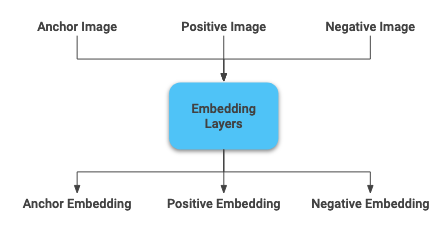

Notice that the strategy variable has made an appearance again. This replicates whatever model is defined for each of the TPU chips and works out how to merge the model again once the training ends.

In [ ]:
class GeMPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, p=1., eps=1e-6):
        super().__init__()
        self.p = p
        self.eps = eps

    def call(self, inputs: tf.Tensor, **kwargs):
        inputs = tf.clip_by_value(
            inputs, 
            clip_value_min=self.eps, 
            clip_value_max=tf.reduce_max(inputs)
        )
        inputs = tf.pow(inputs, self.p)
        inputs = tf.reduce_mean(inputs, axis=[1, 2], keepdims=False)
        inputs = tf.pow(inputs, 1. / self.p)
        
        return inputs
    
    def get_config(self):
        return {
            'p': self.p,
            'eps': self.eps
        }

In [ ]:
reg = tf.keras.regularizers

with strategy.scope():
    # backbone
    backbone = tf.keras.applications.Xception(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    )
    
    backbone.trainable = False
    
    # embedding model
    x_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = backbone(x_input)
    x = GeMPoolingLayer()(x)
    x = tf.keras.layers.Dense(EMBED_SIZE, activation='softplus', kernel_regularizer=reg.l2(), dtype='float32')(x)

    embedding_model = tf.keras.models.Model(inputs=x_input, outputs=x, name="embedding")

    # anchor encoding
    anchor_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='anchor_input')
    anchor_x = embedding_model(anchor_input)

    # positive encoding
    positive_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='positive_input')
    positive_x = embedding_model(positive_input)

    # anchor encoding
    negative_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='negative_input')
    negative_x = embedding_model(negative_input)

    # construct model
    model = tf.keras.models.Model(
        inputs=[anchor_input, positive_input, negative_input], 
        outputs=[anchor_x, positive_x, negative_x]
    )

In [ ]:
embedding_model.summary()

Now define the triplet loss function. This function splits the model output into its three parts and then compares the anchor embeddings to the positive and negative embeddings. A reduce sum has also been added at the end as the batch size is likely to push more than one triplet set through on a single step.

In [ ]:
def triplet_loss(y_true, y_pred, alpha=0.2):     
    anchors = y_pred[0]
    positives = y_pred[1]
    negatives = y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchors, positives)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchors, negatives)), axis=-1)

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))

    return loss

Compile the model with the loss function and the adam optimizer.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=RATE),
    loss = triplet_loss
)

Add a couple of callbacks to catch the model if successive epochs are not converging.

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

Finally train the model.

In [ ]:
history = model.fit_generator(
    train_data,
    epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    callbacks = callbacks,
)

## Evaluate

To evaluate the model, let's begin with a simple loss curve.

In [ ]:
plt.title('Model loss')
plt.plot(history.history['loss'])

Next we can eyeball some results. Here I'll use the five triplet sets that I displayed earlier in this notebook. I'll pass them through the model and calculate the euclidean distance between the anchor and the positive and negative embeddings.

In [ ]:
def distance_test(anchors, positives, negatives):    
    pos_dist = []
    neg_dist = []
    
    anchor_encodings = embedding_model.predict(anchors)
    positive_encodings = embedding_model.predict(positives)
    negative_encodings = embedding_model.predict(negatives)
    
    for i in range(len(anchors)):
        pos_dist.append(
            distance.euclidean(anchor_encodings[i], positive_encodings[i])
        )
        
        neg_dist.append(
            distance.euclidean(anchor_encodings[i], negative_encodings[i])
        )
    
    return pos_dist, neg_dist

In [ ]:
pos_dist, neg_dist = distance_test(anchors[0:5], positives[0:5], negatives[0:5])

Display each triplet set alongside the distance between the anchor and positive images and the anchor and the negative images. The distances are in the positive and negative image titles.

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(15, 20))

for i in range(5):
    axes[i, 0].set_title('Anchor')
    axes[i, 0].imshow(anchors[i])

    axes[i, 1].set_title('Positive dist: {:.2f}'.format(pos_dist[i]))
    axes[i, 1].imshow(positives[i])

    axes[i, 2].set_title('Negative dist: {:.2f}'.format(neg_dist[i]))
    axes[i, 2].imshow(negatives[i])

This competition uses the embeddings created by the model to cluster an image with index images. To see how this model performs it might be worth taking one example image, getting its embeddings and seeing what images it is most similar to.

Begin by getting a sample of 100 images.

In [ ]:
image_ids = pd.read_csv(
    '../input/landmark-retrieval-2020/train.csv',
    nrows=100
)

Next get the pixels for each of the images in the sample and put them in a numpy array.

In [ ]:
def get_image(img_id):    
    chars = [char for char in img_id]
    dir_1, dir_2, dir_3 = chars[0], chars[1], chars[2]
    
    image = Image.open('../input/landmark-retrieval-2020/train/' + dir_1 + '/' + dir_2 + '/' + dir_3 + '/' + img_id + '.jpg')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.asarray(image) / 255.0
    
    return image

In [ ]:
images = [get_image(img_id) for img_id in image_ids.id]
images = np.array(images)

Feed the images into the model to get the embeddings for each one.

In [ ]:
embeddings = embedding_model.predict(images)

Now generate a matrix comparing each image against the others. This gives us a euclidean distance between all the images. The smaller this distance the more similar the model believes the images to be. If we have 100 images in the sample then we will have a matrix of shape (100,100) that contains all the distances.

In [ ]:
distances = distance.cdist(embeddings, embeddings, 'euclidean')
print(distances.shape)

Now get the indexes of the ten images that are closest to each image in the sample.

In [ ]:
predicted_positions = np.argpartition(distances, 10, axis=1)[:, :10]

Now we can have a look at how an example anchor image from this sample compares against all the other images in the dataset. Let's pick an image in the sample.

In [ ]:
anchor_img = get_image(
    image_ids.loc[41].id
)

plt.title('Landmark: {}'.format(image_ids.loc[40].landmark_id))
plt.imshow(anchor_img)

And then get the ten images closest to it including the euclidean distance. There are only four images containing this landmark so there will be some other landmarks that appear in the top ten. If the model is good though the distance for these other landmarks should be lower than the distance for the images containing the same landmark.

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

top_ten_indexes = predicted_positions[41]

for i in range(3):
    for j in range(3):
        img_index = top_ten_indexes[j + (i*3)]
        
        landmark_id = image_ids.loc[img_index].landmark_id
        dist = distances[41, img_index]

        ax[i,j].set_title('landmark: {}, dist: {:.2f}'.format(landmark_id, dist))
        ax[i,j].imshow(
            get_image(image_ids.loc[img_index].id)
        )

Let's have a look at an image containing a different landmark.

In [ ]:
anchor_img = get_image(
    image_ids.loc[80].id
)

plt.imshow(anchor_img)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

top_ten_indexes = predicted_positions[80]

for i in range(3):
    for j in range(3):
        img_index = top_ten_indexes[j + (i*3)]
        
        landmark_id = image_ids.loc[img_index].landmark_id
        dist = distances[80, img_index]

        ax[i,j].set_title('landmark: {}, dist: {:.2f}'.format(landmark_id, dist))
        ax[i,j].imshow(
            get_image(image_ids.loc[img_index].id)
        )

## Save model

Finally save the model. The competition needs the model to accept only one image as input and output only one embedding. I'll only be saving the embedding layers of the model then.

It's worth noting that at the time of writing models trained with TPUs cannot be saved in the tf format. They instead need to be saved as h5 files.

In [ ]:
embedding_model.save(
    'embedding_model.h5', 
    save_format='h5',
    overwrite=True
)

I would also finish this off with the below functions to save the model into the exact format needed for a submission. However the competition does not allow notebook using TPU or the internet to be entered for submission. As such I have moved the below functions into an inference notebook where the h5 file can be loaded and inserted into the below.

First I would load the model from the h5 file I saved it in.

In [ ]:
# model = tf.keras.models.load_model(
#     'embedding_model.h5',
#     custom_objects={'GeMPoolingLayer': GeMPoolingLayer}
# )

Then I would create a class for the model to sit in. This includes the serving function (def call) that the scoring script will use to generate embeddings for the images. This includes applying L2 normalisation to the output to suppress weak embeddings and focus only the embeddings that are descriptive. I've found this helps to lift the models score. I've also loaded the images at a larger size which also helps.

In [ ]:
# class MyModel(tf.keras.Model):
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.model = model
    
#     @tf.function(input_signature=[
#       tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8, name='input_image')
#     ])
    
#     def call(self, input_image):
#         input_image = tf.cast(input_image, tf.float32) / 255.
#         input_image = tf.image.resize(input_image, (512, 512), method='nearest')
        
#         model_outputs = self.model(input_image[tf.newaxis])
#         features = tf.math.l2_normalize(model_outputs[0])
        
#         return {
#             'global_descriptor': tf.identity(features, name='global_descriptor')
#         }

Then save the model class. This will do a full tensorflow save creating directories to hold all the variables.

In [ ]:
# m = MyModel()

# served_function = m.call

# tf.saved_model.save(
#     m, 
#     export_dir="./model", 
#     signatures={'serving_default': served_function}
# )

And then compress all those tensorflow save files into a zip file.

In [ ]:
# from zipfile import ZipFile

# with ZipFile('submission.zip','w') as output_zip_file:
#     for filename in os.listdir('./model'):
#         if os.path.isfile('./model/'+filename):
#             output_zip_file.write('./model/'+filename, arcname=filename) 
    
#     for filename in os.listdir('./model/variables'):
#         if os.path.isfile('./model/variables/'+filename):
#             output_zip_file.write('./model/variables/'+filename, arcname='variables/'+filename)
    
#     for filename in os.listdir('./model/assets'):
#         if os.path.isfile('./model/assets/'+filename):
#             output_zip_file.write('./model/assets/'+filename, arcname='assets/'+filename)